In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.io import loadmat
from scipy.optimize import minimize
# theme
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


## Visualizing the data

In [11]:
data = loadmat('res/ex3data1.mat')
print data.keys()

['y', 'X', '__version__', '__header__', '__globals__']


In [38]:
X = data['X']; y= data['y']

In [39]:
print X.shape
print y.shape

(5000L, 400L)
(5000L, 1L)


In [14]:
m = X.shape[0]
rand_indices= np.random.permutation(np.arange(m))
sel = X[rand_indices[0:100],:]

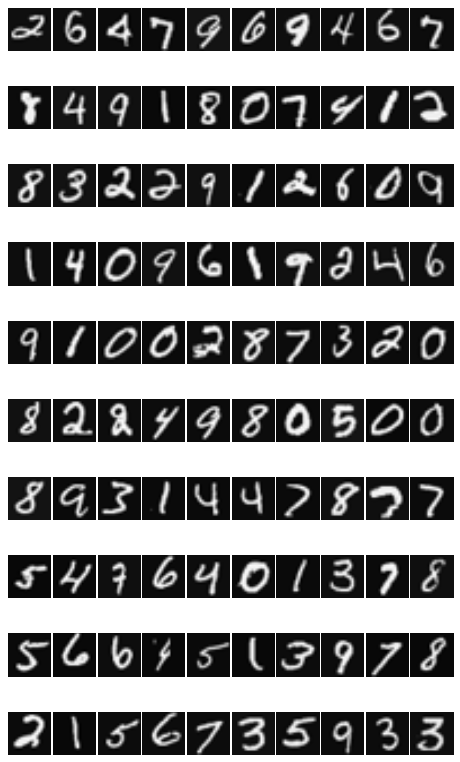

In [15]:
def plot_gallery(images, h=20, w=20, n_row=10, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(0.8 * n_col, 1.4 * n_row))
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    #plt.tight_layout()
    for i in range(n_row * n_col):        
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plot_gallery(sel)

## Model representation

![Neural Network](image/nn.png)

In [16]:
# reading pre-trained weights
w = loadmat('res/ex4weights.mat')
print w.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']


In [17]:
Theta1 = w['Theta1']
Theta2 = w['Theta2']

In [18]:
# this is the forward pass, no backpropagation
def predict(Theta1, Theta2, X):
    X = np.c_[np.ones((X.shape[0],1)),X]
    z2 = Theta1.dot(X.T)
    a2 = np.c_[np.ones((X.shape[0],1)), sigmoid(z2).T]
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    return(np.argmax(a3, axis=1)+1)   

#### Cost function for neural networks

#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$


#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [19]:
print X.shape
print Theta1.shape
print Theta2.shape

(5000L, 400L)
(25L, 401L)
(10L, 26L)


In [20]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [21]:
def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

##### NN Parameters

Input shape: (5000,400)

Hidden layer: (25)

Theta1 weights: (401,25)

Theta2 weights: (10,26)

Output classes: (10)

In [42]:
def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,reg):
    # nn_params is a flattened version of weights of the neural network, took me some time to figure it out!
    # reshaping nn_params into Theta1,Theta2
    # Theta1 (25L, 401L)
    Theta1 = nn_params[0:hidden_layer_size * (input_layer_size+1)].reshape(hidden_layer_size, (input_layer_size + 1))
    # Theta2 (10L, 26L)
    Theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))
    # no. of samples
    m = X.shape[0]
    # initialize cost
    J = 0
    # initialize gradients
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    # encode features
    y_encoded = pd.get_dummies(np.ravel(y)).as_matrix()
    ###############################################
    # forward pass, don't look back, just compute J
    a1 = X
    # Theta 25,401 X.T 401,5000 z2 25,5000
    z2 = Theta1.dot(a1.T)
    a2 = np.c_[np.ones((X.shape[0],1)), sigmoid(z2).T]
    # another pass
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    J = -1*(1/m)*np.sum((np.log(a3.T)*(y_encoded)+np.log(1-a3).T*(1-y_encoded))) + \
        (reg/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))           
    ###############################################
    ###############################################
    # backpropagating into the network, and calcul-
    # ating gradeints
    d3 = a3.T - y_encoded
    d2 = theta2[:,1:].T.dot(d3.T)*sigmoidGradient(z2)
    
    delta1 = d2.dot(a1)
    delta2 = d3.T.dot(a2) 
    theta1_ = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = delta1/m + (theta1_*reg)/m
    theta2_grad = delta2/m + (theta2_*reg)/m
    
    return(J, theta1_grad, theta2_grad)

In [35]:
params = np.r_[Theta1.ravel(), Theta2.ravel()]

In [40]:
X = np.c_[np.ones((X.shape[0],1)), X]

In [43]:
# Regularization parameter = 0
nnCostFunction(params, 400, 25, 10, X, y, 0)[0]

ValueError: operands could not be broadcast together with shapes (10,5000) (5000,10) 